# Cornell Movie
This is the script written by Zach Monge corresponding to the blog post __["You can't handle the truth!" Transfer learning to detect memorable movie quotes](https://medium.com/@zachmonge)__. This notebook was ran on a 15" Windows Surface Book2 with a NVIDIA GeForce GTX 1060 GPU.<br><br>Here, I am using the Cornell Movie-Quotes Corpus, which is publicly available at http://www.cs.cornell.edu/~cristian/memorability.html. The dataset consists of memorable movie quotes and matached non-memorable quotes.

In [1]:
# Importing functions
from fastai.text import *
import html

C:\Users\zachm\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Standardizing Data
Before training the model, putting the data into a standardized format. Here, the data will be put into a pandas dataframe with two columns: label (0=memorable, 1=non-memorable) and text (the quote). 

In [2]:
#Path to data
PATH=Path('data/cornell_movie_quotes/')
TEXT_PATH=PATH/'moviequotes.memorable_nonmemorable_pairs.txt'

Reading in text, seperating by new line, and putting into numpy array.

In [3]:
# Reading in text, seperating by new line, and putting into
# numpy array.
text=TEXT_PATH.open('r', encoding="ISO-8859-1").read()
text=text.split('\n')
text = np.array(text)

In [4]:
text[2]

'875814 My mom would kill me if she knew I took the Rover.'

Getting the indices of the memorable and non-memorable quotes, and creating seperate numpy arrays for each class.

In [5]:
mem_idx = np.arange(2, len(text)-1, step=5) # Every 5th line starting at 2
nmem_idx = np.arange(3, len(text)-1, step=5) # Every 5th line starting at 3

mem_text=text[mem_idx]
nmem_text=text[nmem_idx]

In front of each quote is the corresponding line number within the script. Below we remove these numbers.<br>We also add in the label numbers: 0 = memorable, 1 = non-memorable

In [6]:
mem_text_strip = []
mem_text_label = []
for o in mem_text:
    mem_text_strip.append(o.lstrip('0123456789.- ')) # Stripping number and adding to list
    mem_text_label.append(0) # Adding in class label
    
nmem_text_strip = []
nmem_text_label = []
for o in nmem_text:
    nmem_text_strip.append(o.lstrip('0123456789.- ')) # Stripping number and adding to list
    mem_text_label.append(1) # Adding in class label
    
# Putting the lists in numpy arrays
mem_text_strip = np.array(mem_text_strip)
mem_text_label = np.array(mem_text_label)
nmem_text_strip = np.array(nmem_text_strip)
nmem_text_label = np.array(nmem_text_label)

# Concatenating all of the text and labels into one array
text = np.concatenate([mem_text_strip, nmem_text_strip])
label = np.concatenate([mem_text_label, nmem_text_label])

Randomizing order of text/labels

In [7]:
# Randomize everything
np.random.seed(42)
ran_idx = np.random.permutation(len(text))

text_rand = text[ran_idx]
label = label[ran_idx]

Putting labels and text into pandas dataframe

In [8]:
col_names = ['label', 'text']
df = pd.DataFrame({'label':np.int64(label), 'text':text_rand}, columns=col_names)

In [9]:
df.to_csv(PATH/'mem_nmem.csv', index=False)

In [10]:
df = pd.read_csv(PATH/'mem_nmem.csv')

In [11]:
df.head()

,label,text
0,1,"Buddy, this is a private party."
1,1,So we'll need you to go home and bring in ever...
2,0,Welcome to the future... brother.
3,0,"My enemy's enemy is my friend, no? So, come in..."
4,1,"What's happiness to you, David?"


# Preparing Language Model
Before creating classifier, will train a language model, which will predict the next word in a sequence

In [12]:
# Path to data
LM_PATH = PATH/'LM/'
LM_PATH.mkdir(exist_ok=True)

Creating training and validation sets for language model

In [13]:
# Validation set is 10% of total
X_train, X_val, y_train, y_val=sklearn.model_selection.train_test_split(
    df['text'].values, df['label'].values, test_size = 0.1, random_state=42)

# Putting into pandas dataframe
LM_trn_df = pd.DataFrame({'label':y_train, 'text':X_train},columns=col_names)
LM_val_df = pd.DataFrame({'label':y_val, 'text':X_val},columns=col_names)

# Setting label to 0 since we don't need to know the label for the language model
LM_trn_df['label']=0
LM_val_df['label']=0

In [14]:
# Saving to csv
LM_trn_df.to_csv(LM_PATH/'LM_trn.csv',index=False, header=False)
LM_val_df.to_csv(LM_PATH/'LM_val.csv',index=False, header=False)

Reading in the pandads dataframe in chunks. This is a pretty small dataset so it doesn't help that much here, but this can greatly speed up the tokenization process in larger datasets.

In [15]:
chunksize=400

LM_trn_df = pd.read_csv(LM_PATH/'LM_trn.csv', chunksize=chunksize, header=None)
LM_val_df = pd.read_csv(LM_PATH/'LM_val.csv', chunksize=chunksize, header=None)

Below we are tokenizing the text. We are using the fastai tokenizer which esentially uses spaCy. The code below was taken from the fastai course.

In [16]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

re1 = re.compile(r'  +')

# These are fixes for changes commonly found in text
def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

# Applying the tokenizer
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

# Function to be applied to pandas dataframe to tokenize text
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        #print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [17]:
trn_tok, trn_label = get_all(LM_trn_df,1)
val_tok, val_label = get_all(LM_val_df,1)

In [18]:
trn_tok[0][:5]

['\n', 'xbos', 'xfld', '1', 'bumpy']

Calculating the most frequent tokens. We are only going to use tokens that appear more than twice.

In [19]:
freq=Counter(p for o in trn_tok for p in o)
freq.most_common(25)

[('1', 3959),
 ('\n', 3954),
 ('xbos', 3954),
 ('xfld', 3954),
 ('.', 3597),
 (',', 2407),
 ('you', 1798),
 ('i', 1779),
 ('the', 1517),
 ('a', 1176),
 ('to', 1144),
 ('?', 767),
 ("'s", 756),
 ('and', 742),
 ('of', 678),
 ('it', 671),
 ("n't", 663),
 ('that', 566),
 ('in', 537),
 ('...', 533),
 ('do', 517),
 ('!', 498),
 ('is', 451),
 ('me', 419),
 ('we', 387)]

Creating inter-to-string array. Again, only want tokens that appear at least twice

In [20]:
min_freq = 2
itos=[o for o,c in freq.most_common() if c>min_freq]
itos.insert(0, '_pad_') # Adding in padding token
itos.insert(0, '_unk_') # Adding in token to represent unknown tokens

Creating mapping in the opposite direction: string-to-integer. Using a deafultdict so later on we can set unknown tokens to the unknown toke (number 0).

In [21]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

# Taking string tokens and converting them into integers
trn_lm = [[stoi[o] for o in p]for p in trn_tok] # training tokens
val_lm = [[stoi[o] for o in p]for p in val_tok] # validations tokens

Saving language model and the itos array for future use.

In [22]:
(LM_PATH/'tmp').mkdir(exist_ok = True)
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [24]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [23]:
# Size of vocab
vs = len(itos)
vs

1545

# Wikitext103 conversion
We are going to finetune a language model that was already pretrained on a subset of Wikipedia. This pretrained model is publicly available at http://files.fast.ai/models/wt103/
The details of the model architecture and training are available in this paper -- [ULMFiT](https://arxiv.org/abs/1801.06146)
<br><br> We need to use the same parameteters as the pretrained model

In [25]:
# Model parameters
em_sz,nh,nl = 400,1150,3 # embedding size, number of hidden activations, number of layers

# Path to pretrained langauge model
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

# Loading in pretrained model weights
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

It's possible that there are tokens within the movie quotation library that are not contained in the Wikipedia vocab. For those tokens we are going to assign the embedding weights to be the average of the Wikipedia embedding weights

In [26]:
enc_wgts=to_np(wgts['0.encoder.weight']) # embedding weights
row_miss = enc_wgts.mean(0)

Loading in the intger-to-string array for the pretrained model and creating a string-to-integer dictionary

In [27]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))

# Using collection dictionary so can later assign movie tokens that are not found in the Wikipedia vocab
stoi2 = collections.defaultdict(lambda: -1, {v:k for k,v in enumerate(itos2)}) 

Creating array in which the new weights will be assigned. This is size vocab size by embedding size

In [28]:
new_w = np.zeros((vs,em_sz), dtype=np.float32)

Getting embedding weights from Wikipedia model. Again, missing rows get the average

In [29]:
for i,j in enumerate(itos):
    r = stoi2[j]
    new_w[i] = enc_wgts[r] if r>0 else row_miss

Copying in new embedding weights for our vocab in the embedding encoder and decoder. The embeddings for the encoder and decoder are exactly the same as this has previously been shown to help with training.

In [30]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

# Training language model

Finally almost ready to start training. Even though we already have a pretrained language model, this model was trained on Wikipedia which may be different from our corpus of text. So we are going to finetune this model on the movie quotes dataset. I actually found that this step did not help improve the classifier accuracy on whether the quote was memorable or not. This is likely because our vocabulary size was very small (see below). But I am including this step for your reference.<br><br>We specify a few parameters below

In [31]:
wd = 1e-7 # weight decay
bptt = 30 # backpropagation through time; make as large as your memory can handle
bs = 52 # batch size
opt_fn = partial(optim.Adam, betas=(0.8, 0.99)) # model optimizer

Putting data into a data loader

In [32]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

Creating learner which is the model.

In [33]:
# I found that this model required a somewhat high amount of dropout, likely because the dataset is small
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*2.0
learner = md.get_model(opt_fn, em_sz, nh, nl,
                      dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy] # So we can view the accuracy during training
learner.freeze_to(-1) # We will first only train the embedding layers
learner.model.load_state_dict(wgts) # Loading in pretrained weights

Before training, we need to choose the learning rate, so we use the lr_find function

In [35]:
# Need to run this twice to get it to work for some reason...
learner.lr_find()

epoch      trn_loss   val_loss   accuracy                                                                              
    0      13.257772  97.052884  0.06257   



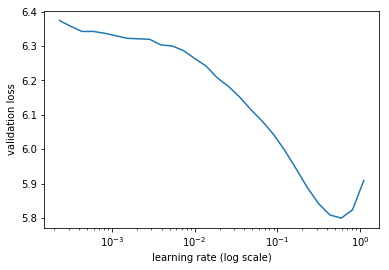

In [36]:
learner.sched.plot()

We'll choose a learning rate of 1e-2 since the loss is still dropping at this point.<br> Now lets start training!

In [37]:
lr = 1e-2
learner.fit(lr, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      5.452861   4.000355   0.262585  



[4.000354826450348, 0.262584924697876]

Just to note we are using slanted triangular learning rates (see the [ULMFiT paper](https://arxiv.org/abs/1801.06146) for an explanation), which is specified with 'use_clr'.

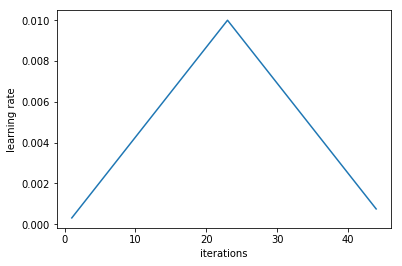

In [38]:
learner.sched.plot_lr()

In [39]:
# Saving model
learner.save('lm0')

In [40]:
# Loading model
learner.load('lm0')

Now lets unfreeze all of the layers

In [41]:
learner.unfreeze()

In [42]:
learner.lr_find()

 95%|███████████████████████████████████████████████████████████████████▊   | 42/44 [00:06<00:00,  5.98it/s, loss=14.5]


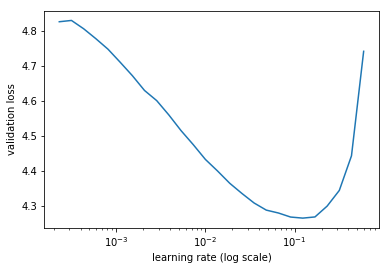

In [43]:
learner.sched.plot()

In [44]:
# Making the learning rate a little bit smaller
learner.fit(lr/10, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.12872    3.209913   0.389636  
    1      3.714757   3.08553    0.394711                                                                              
    2      3.523358   2.999937   0.409712                                                                              
    3      3.418595   2.974704   0.416637                                                                              
    4      3.331541   2.861068   0.431087                                                                              
    5      3.269611   2.943939   0.417366                                                                              
    6      3.217839   2.929552   0.422634                                                                              
    7      3.178505   2.913657   0.425362                                                                           

[2.9050599336624146, 0.4260410964488983]

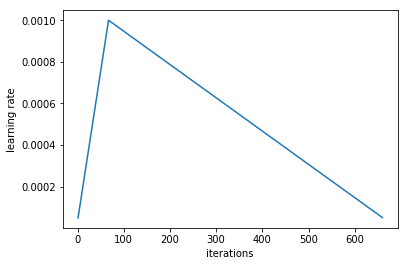

In [45]:
learner.sched.plot_lr()

In [46]:
learner.fit(lr/10, 1, wds=wd, use_clr=(20,10), cycle_len=10)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.03473    2.925125   0.425038  
    1      3.025429   2.902944   0.426554                                                                              
    2      3.00678    2.913681   0.42629                                                                               
    3      2.992722   2.914043   0.429837                                                                              
    4      2.949878   2.919927   0.422915                                                                              
    5      2.92893    2.908112   0.427838                                                                              
    6      2.885401   2.902589   0.433242                                                                              
    7      2.867787   2.904463   0.433533                                                                           

[2.8818057775497437, 0.4360722750425339]

In [48]:
learner.save('lm1')

In [47]:
learner.save_encoder('lm1_enc')

In [49]:
learner.load('lm1')

# Classifier tokens
Now that we have finetuned our model, we can start preparing it to detect whether a movie quote is memorable or note. First need to create tokens for the classifier

In [50]:
CLASS_trn_df = pd.DataFrame({'label':y_train, 'text':X_train},columns=col_names)
CLASS_val_df = pd.DataFrame({'label':y_val, 'text':X_val},columns=col_names)

In [51]:
CLASS_PATH = PATH/'class'
CLASS_PATH.mkdir(exist_ok=True)

In [52]:
# Taken from fastai course

re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

   # tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    tok = Tokenizer.proc_all(texts,'en')
    return tok, list(labels)

def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        #print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [53]:
CLASS_trn_df.to_csv(CLASS_PATH/'class_trn.csv', header=False, index=False)
CLASS_val_df.to_csv(CLASS_PATH/'class_val.csv', header=False, index=False)

In [54]:
chunksize=400

In [55]:
CLASS_trn_df = pd.read_csv(CLASS_PATH/'class_trn.csv', header=None, chunksize=chunksize)
CLASS_val_df = pd.read_csv(CLASS_PATH/'class_val.csv', header=None, chunksize=chunksize)

In [56]:
tok_class_trn, label_class_trn = get_all(CLASS_trn_df, 1)
tok_class_val, label_class_val = get_all(CLASS_val_df, 1)

In [57]:
(CLASS_PATH/'tmp').mkdir(exist_ok=True)

In [58]:
np.save(CLASS_PATH/'tmp'/'tok_class_trn.npy',tok_class_trn)
np.save(CLASS_PATH/'tmp'/'tok_class_val.npy',tok_class_val)

np.save(CLASS_PATH/'tmp'/'label_class_trn.npy',label_class_trn)
np.save(CLASS_PATH/'tmp'/'label_class_val.npy',label_class_val)

In [59]:
tok_class_trn = np.load(CLASS_PATH/'tmp'/'tok_class_trn.npy')
tok_class_val = np.load(CLASS_PATH/'tmp'/'tok_class_val.npy')

label_class_trn = np.load(CLASS_PATH/'tmp'/'label_class_trn.npy')
label_class_val = np.load(CLASS_PATH/'tmp'/'label_class_val.npy')

In [60]:
#Loading in itos from language model
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

In [61]:
trn_class = [[stoi[o] for o in p] for p in tok_class_trn]
val_class = [[stoi[o] for o in p] for p in tok_class_val]

In [62]:
np.save(CLASS_PATH/'tmp'/'trn_ids.npy', trn_class)
np.save(CLASS_PATH/'tmp'/'val_ids.npy', val_class)

# Training the classifier
Now that we've tokenzied the text, we can start training the classifier

In [81]:
# Loading in the ids and corresponding labels
trn_class = np.load(CLASS_PATH/'tmp'/'trn_ids.npy')
val_class = np.load(CLASS_PATH/'tmp'/'val_ids.npy')

label_class_trn = np.squeeze(np.load(CLASS_PATH/'tmp'/'label_class_trn.npy'))
label_class_val = np.squeeze(np.load(CLASS_PATH/'tmp'/'label_class_val.npy'))

In [82]:
wd = 1e-7 # weight decay
bptt = 30 # backpropagation through time
bs = 48 # batch size
opt_fn = partial(optim.Adam, betas=(0.8, 0.99)) # optimizer function
vs = len(itos) # vocab size

# Model parameters
em_sz,nh,nl = 400,1150,3

In [83]:
min_lbl = label_class_trn.min()
label_class_trn -= min_lbl
label_class_val -= min_lbl

In [84]:
# Number of classes
c = int(label_class_trn.max()) + 1

In [85]:
# Creating the dataset
trn_ds = TextDataset(trn_class, label_class_trn)
val_ds = TextDataset(val_class, label_class_val)

Below SortishSampler is sorting the text by the size of each document. This is so the padding within each text document is somewhat similar in a batch.

In [86]:
trn_samp = SortishSampler(trn_ds, key = lambda x: len(trn_class[x]), bs=bs//2)
val_samp = SortishSampler(val_ds, key = lambda x: len(val_class[x]), bs=bs)

In [87]:
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1)

In [88]:
md = ModelData(PATH, trn_dl, val_dl)

In [89]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [90]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [91]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [92]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)

In [93]:
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip = .25
learn.metrics = [accuracy]

In [94]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])
wd = 1e-7

Loading in the encoder from the finetuned language model.

In [95]:
learn.load_encoder('lm1_enc')

In [96]:
learn.freeze_to(-1)

In [98]:
learn.lr_find(lrs/1000)

 87%|███████████████████████████████████████████████████████████▊         | 143/165 [00:11<00:01, 14.47it/s, loss=2.55]

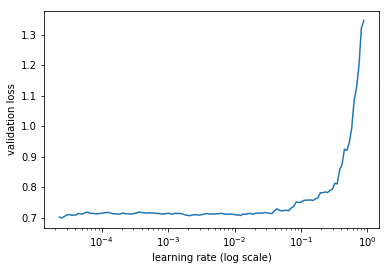

In [99]:
learn.sched.plot()

In [100]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.686049   0.666904   0.572727  


[0.6669035174629905, 0.5727272868156433]

In [101]:
learn.freeze_to(-2)

In [102]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.671366   0.664654   0.565909  


[0.6646540663459084, 0.5659091114997864]

In [103]:
learn.unfreeze()

In [104]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.65184    0.682121   0.559091  
    1      0.657402   0.61176    0.631818                                                                              
    2      0.631534   0.611522   0.661364                                                                              
    3      0.605533   0.58867    0.659091                                                                              
    4      0.574045   0.579837   0.679545                                                                              
    5      0.559845   0.563656   0.686364                                                                              
    6      0.545252   0.561375   0.713636                                                                              
    7      0.52326    0.551624   0.7                                                                                

[0.5492677753621882, 0.7113636602054942]

# Backwards
A way we can even further improve this model is to do everything backwards. There are already pretrained weights with the backwards language model. The below code is almost exactly the same as above except the order of the tokens is backwards!

## Wikitext103 conversion
We are going to finetune a language model that was already pretrained on a subset of Wikipedia. This pretrained model is publicly available at http://files.fast.ai/models/wt103/
The details of the model architecture and training are available in this paper -- [ULMFiT](https://arxiv.org/abs/1801.06146)
<br><br> We need to use the same parameteters as the pretrained model

In [105]:
# Model parameters
em_sz,nh,nl = 400,1150,3 # embedding size, number of hidden activations, number of layers

# Path to pretrained langauge model
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH_BW = PRE_PATH/'bwd_wt103.h5'

# Loading in pretrained model weights
wgts_bw = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

It's possible that there are tokens within the movie quotation library that are not contained in the Wikipedia vocab. For those tokens we are going to assign the embedding weights to be the average of the Wikipedia embedding weights

In [106]:
enc_wgts_bw=to_np(wgts['0.encoder.weight']) # embedding weights
row_miss_bw = enc_wgts_bw.mean(0)

Loading in the intger-to-string array for the pretrained model and creating a string-to-integer dictionary

In [107]:
itos2_bw = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))

# Using collection dictionary so can later assign movie tokens that are not found in the Wikipedia vocab
stoi2_bw = collections.defaultdict(lambda: -1, {v:k for k,v in enumerate(itos2_bw)}) 

Creating array in which the new weights will be assigned. This is size vocab size by embedding size

In [108]:
new_w_bw = np.zeros((vs,em_sz), dtype=np.float32)

Getting embedding weights from Wikipedia model. Again, missing rows get the average

In [109]:
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
for i,j in enumerate(itos):
    r = stoi2[j]
    new_w[i] = enc_wgts[r] if r>0 else row_miss

Copying in new embedding weights for our vocab in the embedding encoder and decoder. The embeddings for the encoder and decoder are exactly the same as this has previously been shown to help with training.

In [110]:
wgts_bw['0.encoder.weight'] = T(new_w_bw)
wgts_bw['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w_bw))
wgts_bw['1.decoder.weight'] = T(np.copy(new_w_bw))

## Training language model

Finally almost ready to start training. Even though we already have a pretrained language model, this model was trained on Wikipedia which may be different from our corpus of text. So we are going to finetune this model on the movie quotes dataset. I actually found that this step did not help improve the classifier accuracy on whether the quote was memorable or not. This is likely because our vocabulary size was very small (see below). But I am including this step for your reference.<br><br>We specify a few parameters below

In [111]:
wd = 1e-7 # weight decay
bptt = 30 # backpropagation through time; make as large as your memory can handle
bs = 52 # batch size
opt_fn = partial(optim.Adam, betas=(0.8, 0.99)) # model optimizer

Putting data into a data loader

In [112]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')

In [113]:
trn_dl_bw = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt, backwards=True)
val_dl_bw = LanguageModelLoader(np.concatenate(val_lm), bs, bptt, backwards=True)
md_bw = LanguageModelData(PATH, 1, vs, trn_dl_bw, val_dl_bw, bs=bs, bptt=bptt)

Creating learner which is the model.

In [114]:
# I found that this model required a somewhat high amount of dropout, likely because the dataset is small
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*2.0
learner_bw = md_bw.get_model(opt_fn, em_sz, nh, nl,
                      dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner_bw.metrics = [accuracy] # So we can view the accuracy during training
learner_bw.freeze_to(-1) # We will first only train the embedding layers
learner_bw.model.load_state_dict(wgts_bw) # Loading in pretrained weights

Before training, we need to choose the learning rate, so we use the lr_find function

In [117]:
# Need to run this twice to get it to work for some reason...
learner_bw.lr_find()

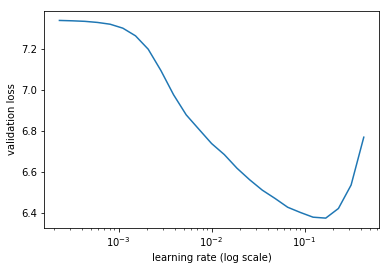

In [118]:
learner_bw.sched.plot()

We'll choose a learning rate of 1e-2 since the loss is still dropping at this point.<br> Now lets start training!

In [119]:
lr = 1e-2
learner_bw.fit(lr, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      5.212331   4.831603   0.104414  


[4.8316028118133545, 0.10441417060792446]

Just to note we are using slanted triangular learning rates (see the [ULMFiT paper](https://arxiv.org/abs/1801.06146) for an explanation), which is specified with 'use_clr'.

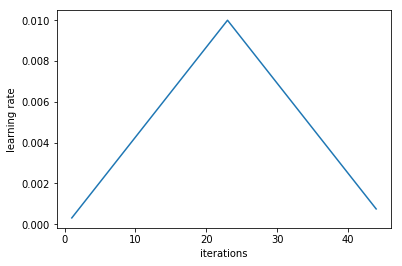

In [120]:
learner_bw.sched.plot_lr()

In [121]:
# Saving model
learner_bw.save('lm0_bw')

In [123]:
# Loading model
learner_bw.load('lm0_bw')

Now lets unfreeze all of the layers

In [122]:
learner_bw.unfreeze()

In [124]:
learner_bw.lr_find()

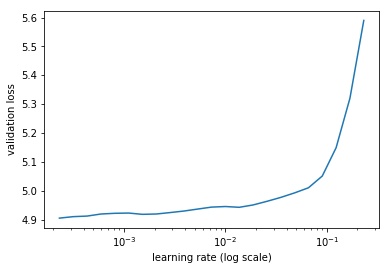

In [125]:
learner_bw.sched.plot()

In [126]:
# Making the learning rate a little bit smaller
learner_bw.fit(lr/10, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      4.916423   4.795455   0.108168  
    1      4.83306    4.308701   0.300894                                                                              
    2      4.437049   3.960989   0.335209                                                                              
    3      4.183606   3.84206    0.335895                                                                              
    4      4.024445   3.74482    0.342983                                                                              
    5      3.909677   3.688813   0.342764                                                                              
    6      3.837859   3.631556   0.353456                                                                              
    7      3.772087   3.604287   0.356289                                                                           

[3.4844263195991516, 0.3671947941184044]

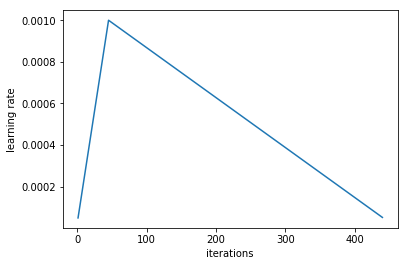

In [128]:
learner_bw.sched.plot_lr()

In [127]:
learner_bw.fit(lr/10, 1, wds=wd, use_clr=(20,10), cycle_len=10)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      3.573921   3.480783   0.367463  
    1      3.551531   3.480586   0.364721                                                                              
    2      3.537192   3.409223   0.374968                                                                              
    3      3.488168   3.390296   0.379337                                                                              
    4      3.464058   3.381378   0.379133                                                                              
    5      3.434512   3.377196   0.379705                                                                              
    6      3.414784   3.35917    0.384252                                                                              
    7      3.398761   3.346018   0.384788                                                                           

[3.3489245176315308, 0.3829425573348999]

In [130]:
learner_bw.save('lm1_bw')

In [131]:
learner_bw.save_encoder('lm1_enc_bw')

In [129]:
learner_bw.load('lm1_bw')

## Training the classifier

In [132]:
# Loading in the ids and corresponding labels
trn_class = np.load(CLASS_PATH/'tmp'/'trn_ids.npy')
val_class = np.load(CLASS_PATH/'tmp'/'val_ids.npy')

label_class_trn = np.squeeze(np.load(CLASS_PATH/'tmp'/'label_class_trn.npy'))
label_class_val = np.squeeze(np.load(CLASS_PATH/'tmp'/'label_class_val.npy'))

In [133]:
wd = 1e-7
bptt = 30
bs = 48
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
vs = len(itos)

# Model parameters
em_sz,nh,nl = 400,1150,3

In [134]:
min_lbl = label_class_trn.min()
label_class_trn -= min_lbl
label_class_val -= min_lbl

In [135]:
# Number of classes
c = int(label_class_trn.max()) + 1

In [136]:
trn_ds_bw = TextDataset(trn_class, label_class_trn, backwards = True)
val_ds_bw = TextDataset(val_class, label_class_val, backwards = True)

In [137]:
trn_samp_bw = SortishSampler(trn_ds, key = lambda x: len(trn_class[x]), bs=bs//2)
val_samp_bw = SortishSampler(val_ds, key = lambda x: len(val_class[x]), bs=bs)

In [138]:
trn_dl_bw = DataLoader(trn_ds_bw, bs//2, transpose=True, num_workers=1, pad_idx=1)
val_dl_bw = DataLoader(val_ds_bw, bs, transpose=True, num_workers=1, pad_idx=1)

In [139]:
md_bw = ModelData(PATH, trn_dl_bw, val_dl_bw)

In [140]:
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [141]:
m_bw = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [142]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [143]:
learn_bw = RNN_Learner(md_bw, TextModel(to_gpu(m_bw)), opt_fn=opt_fn)

In [144]:
learn_bw.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn_bw.clip = .25
learn_bw.metrics = [accuracy]

In [145]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])
wd = 1e-7

In [146]:
learn_bw.load_encoder('lm1_enc_bw')

In [147]:
learn_bw.freeze_to(-1)

In [149]:
learn_bw.lr_find(lrs/1000)

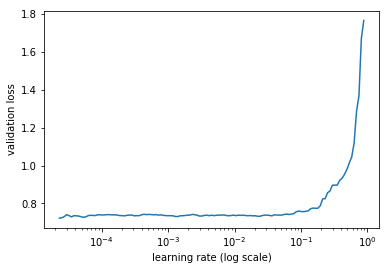

In [150]:
learn_bw.sched.plot()

In [151]:
learn_bw.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.688493   0.664344   0.586364  


[0.664344357360493, 0.5863636612892151]

In [152]:
learn_bw.freeze_to(-2)

In [153]:
learn_bw.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.68213    0.665676   0.540909  


[0.6656763835386796, 0.5409091006625782]

In [154]:
learn_bw.unfreeze()

In [155]:
learn_bw.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.668368   0.642631   0.593182  
    1      0.66532    0.634599   0.602273                                                                              
    2      0.634799   0.606316   0.638636                                                                              
    3      0.616781   0.585194   0.652273                                                                              
    4      0.596538   0.579567   0.65                                                                                  
    5      0.584889   0.569915   0.65                                                                                  
    6      0.574505   0.572916   0.665909                                                                              
    7      0.578976   0.565534   0.675                                                                              

[0.5702939038926905, 0.6750000151720914]

# Final Model Prediction
Now that we've trained the classifier on both the forward and backward model, lets see the final prediciton accuracy using both models. It turns out that this made our model prediction worse, but this is worth checking with your own datasets

In [156]:
# Predictions from forward model
preds_fw = learn.predict_dl(learn.data.val_dl)

In [157]:
# Predictions from backward model
preds_bw = learn_bw.predict_dl(learn_bw.data.val_dl)

In [158]:
# Concatenate predictions and find max
preds_concat = np.concatenate((preds_fw, preds_bw),axis=1)
preds_concat_max = np.argmax(preds_concat, axis=1)
preds_concat_max[preds_concat_max == 2] = 0 # 2 is actually 0
preds_concat_max[preds_concat_max == 3] = 1 # 3 is actually 1

In [159]:
np.mean(preds_concat_max == learn.data.val_ds[:][1])

0.7090909090909091